---
title: "Draw Porkchop Plot from Earth to Mars" \
author: "Naoya Ozaki" \
date: "21 August 2022" \
output: "earth2mars_porkchop"

---

## 1. SPICE Setup
Import SPICE library and download generic kernels.
This process takes long time because of downloading the large file (~120MB).

In [1]:
import SPICE
using Downloads

# Download generic kernels
genker_naif0012 = Downloads.download("https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls")
genker_gm_de431 = Downloads.download("https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/gm_de431.tpc")
genker_de440 = Downloads.download("https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets//de440.bsp")

# Load generic kernels
SPICE.furnsh(genker_naif0012) # Leap seconds kernel
SPICE.furnsh(genker_gm_de431) # Gravity Constant
SPICE.furnsh(genker_de440) # Planetary ephemeris kernel

## 2. Solve Lambert's Problem
Solve Lambert's problem as a test case

In [2]:
using LambertProblem
using LinearAlgebra

# Gravity Constant
μ = SPICE.bodvrd("SUN", "GM", 1)[1]

# Flight Time
et1 = SPICE.str2et("2031/03/01 00:00:00 UTC") # 地球出発日時, UTC
et2 = SPICE.str2et("2032/01/01 00:00:00 UTC") # 火星到着日時, UTC
tof = et2 - et1 # 飛行時間

#　Earth and Mars Orbital Element
state_earth, _ = SPICE.spkez(399, et1, "ECLIPJ2000", "NONE", 10)
state_mars, _ = SPICE.spkez(4, et2, "ECLIPJ2000", "NONE", 10)

r1 = state_earth[1:3]
r2 = state_mars[1:3]

# Solve Lambert's Problem
v1, v2, num_sol = lambert_problem(r1,r2,tof,μ,2)

([-12.146901903784704; -30.249196666164888; 1.7328230818673045;;], [-5.062557143526501; 22.77374756805452; -1.0435265077509397;;], 1)

## 3. Run Multiple Lambert's Problems

In [3]:
# Gravity Constant
μ = SPICE.bodvrd("SUN", "GM", 1)[1]

# Flight Time
utc1_ini = "2031/03/01 00:00:00 UTC" # 地球出発日時, UTC
utc2_ini = "2032/01/01 00:00:00 UTC" #  火星到着日時, UTC
et1_ini = SPICE.str2et(utc1_ini) 
et2_ini = SPICE.str2et(utc2_ini)

# Number of Time Grid
delta_et = 1.0*86400 # 5 days -> sec
num_grid_et1 = 1000
num_grid_et2 = 1200

# Declare Data Storage
vinf1_all = zeros(num_grid_et1, num_grid_et2)
vinf2_all = zeros(num_grid_et1, num_grid_et2)

# Iteration
for i = 1:num_grid_et1
    for j = 1:num_grid_et2
        # Calculate Transfer Time
        et1 = et1_ini + (i-1)*delta_et
        et2 = et2_ini + (j-1)*delta_et
        tof_sec = et2 - et1

        if tof_sec > 1.0
            # Get Earth and Mars Positions
            state_earth, _ = SPICE.spkez(399, et1, "ECLIPJ2000", "NONE", 10)
            state_mars, _ = SPICE.spkez(4, et2, "ECLIPJ2000", "NONE", 10)

            # Solve Lambert's Problem
            v1, v2, num_sol = lambert_problem(state_earth[1:3],state_mars[1:3],tof_sec,μ,0)
            vinf1_all[i,j] = norm(v1-state_earth[4:6])
            vinf2_all[i,j] = norm(v2-state_mars[4:6])
        end
    end
end



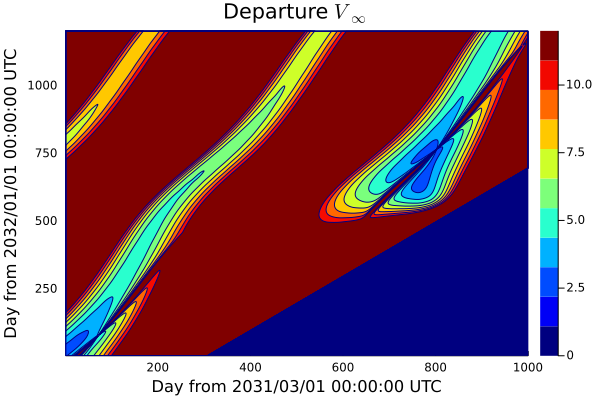

In [6]:
using Plots
using LaTeXStrings
f = contourf(vinf1_all',levels = range(0, 12, length = 12), c = :jet1, 
        xlabel="Day from "*utc1_ini, 
        ylabel="Day from "*utc2_ini,
        clims=(0,12),
        title=L"Departure $V_{\infty}$"
)